In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Estimating the Generalization Error

A regression algorithm tries to estimate a function based on noisy values *y* at a few sample points *x*. Let us prepare an example:

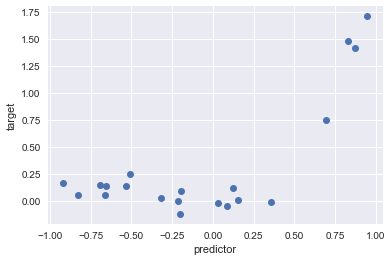

In [254]:
def get_realisation(n_points, std_noise):
    x = np.random.uniform(low=-1, high=1, size=n_points)
    noise = np.random.normal(loc=0, scale=std_noise, size=n_points)
    y = x**2 + x**3 + noise
    return x, y, noise

n_points = 20
std_noise = 0.1
x, y, noise = get_realisation(n_points, std_noise)

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set(xlabel='predictor', ylabel='target');

In [282]:
n_train = int(0.4 * n_points)
n_validation = int(0.4 * n_points)
n_test = n_points - n_train - n_validation

indices = np.arange(n_points)
train = (indices < n_train)
validation = (n_train < indices) & (indices < n_train + n_validation)
test = (n_train + n_validation < indices)

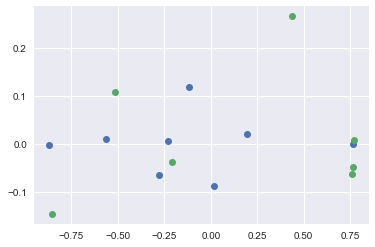

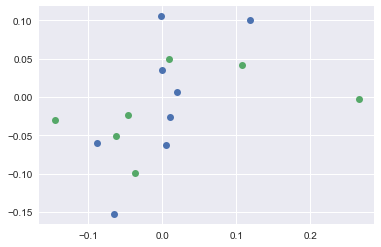

In [305]:
x, y, noise = get_realisation(n_points, std_noise)
x_basis = np.array([np.ones(n_points), x, x**2, x**3, x**4, x**5]).T

cov = np.linalg.inv(np.dot(x_basis[train].T, x_basis[train]))
coeffs = np.dot(cov, np.dot(x_basis[train].T, y[train]))
yhat = np.dot(coeffs, x_basis.T)
error = y - yhat

plt.figure()
plt.plot(x[train], error[train], 'o');
plt.plot(x[validation], error[validation], 'o');

plt.figure()
plt.plot(error[train], noise[train], 'o');
plt.plot(error[validation], noise[validation], 'o');

### in-sample error

The insample error can be estimated from the difference of the predicted with the training samples. Under the assumption that the input noise of y was Gaussian, we can estimate the standard deviation of the noise from the standard deviation of the difference between predicted and training samples. To this end, we have to assume, however, that our model was correct! In this case, the model parameters themselves are t-distributed.

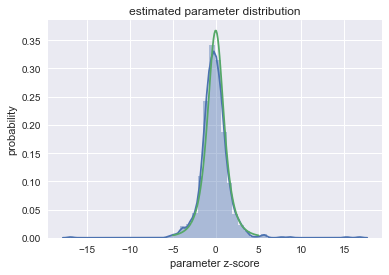

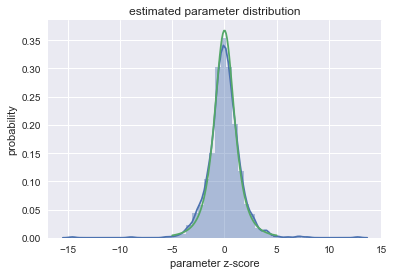

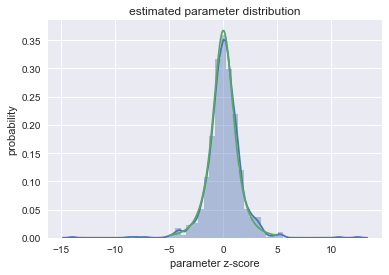

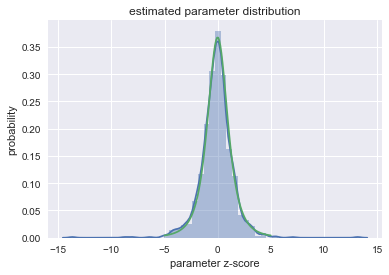

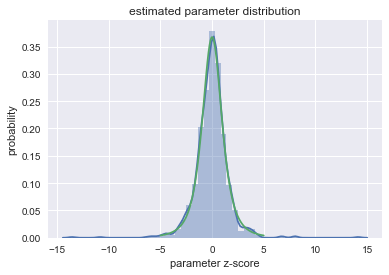

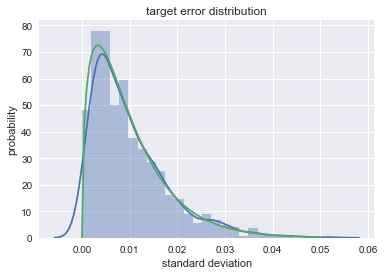

In [322]:
from scipy import stats

n_realisations = 1000

n_coeffs = 5
coefficients = np.empty((n_realisations, n_coeffs))
estimated_y_stds = np.empty(n_realisations)
coefficient_covs = np.empty((n_realisations, n_coeffs))
for irealisation in range(n_realisations):
    x, y, noise = get_realisation(n_points, std_noise)
    x_basis = np.array([np.ones(n_points), x, x**2, x**3, x**4]).T

    cov = np.linalg.inv(np.dot(x_basis[train].T, x_basis[train]))
    coeffs = np.dot(cov, np.dot(x_basis[train].T, y[train]))
    yhat = np.dot(coeffs, x_basis[train].T)
    error = y[train] - yhat
    
    sigma_est = np.sqrt(np.sum(error**2)/(n_train - n_coeffs))
    
    coefficients[irealisation] = coeffs
    estimated_y_stds[irealisation] = sigma_est
    coefficient_covs[irealisation] = np.diag(cov)

z_scores = (coefficients - np.mean(coefficients, axis=0)) /\
            estimated_y_stds[:, None] / np.sqrt(coefficient_covs)
for score in z_scores.T:
    fig, ax = plt.subplots()
    sns.distplot(score, ax=ax, norm_hist=True);

    x_tdist = np.linspace(-5, 5, 100)
    ax.plot(x_tdist, stats.t.pdf(x_tdist, df=n_train-n_coeffs))
    ax.set(xlabel='parameter z-score', ylabel='probability', title='estimated parameter distribution');

mean_estimated_var = np.mean(estimated_y_stds**2)
fig, ax = plt.subplots()
x_chi2 = np.linspace(0., 0.05, 100)
sns.distplot(estimated_y_stds**2, ax=ax, norm_hist=True)
ax.plot(x_chi2, stats.chi2.pdf(x_chi2, n_train-n_coeffs, scale=std_noise**2/(n_train-n_coeffs)))
ax.set(xlabel='standard deviation', ylabel='probability', title='target error distribution');

### extra sample error
this can be measured on the validation dataset

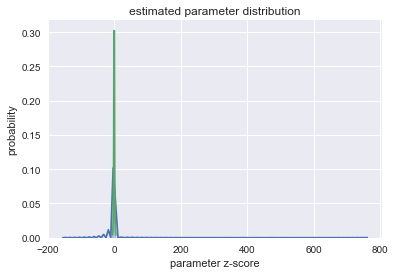

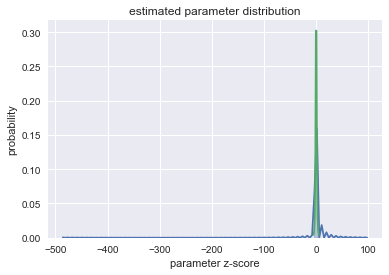

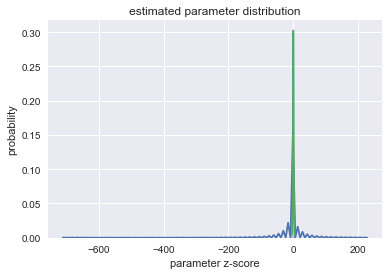

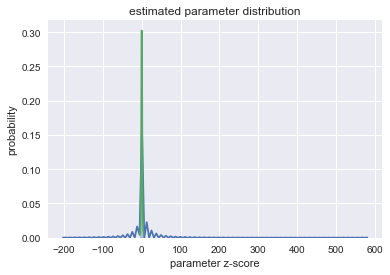

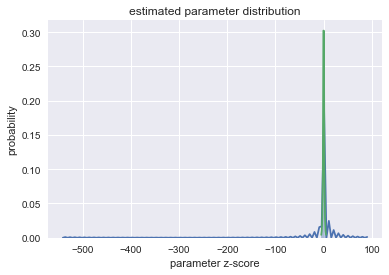

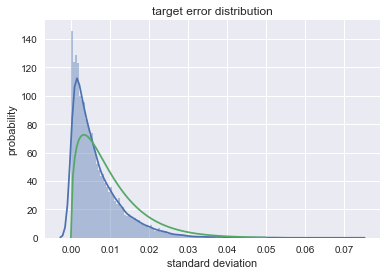

In [323]:
from scipy import stats

n_realisations = 10000

n_coeffs = 5
coefficients = np.empty((n_realisations, n_coeffs))
estimated_y_stds = np.empty(n_realisations)
coefficient_covs = np.empty((n_realisations, n_coeffs))
for irealisation in range(n_realisations):
    x, y, noise = get_realisation(n_points, std_noise)
    x_basis = np.array([np.ones(n_points), x, x**2, x**3, x**4]).T

    cov = np.linalg.inv(np.dot(x_basis[validation].T, x_basis[validation]))
    coeffs = np.dot(cov, np.dot(x_basis[validation].T, y[validation]))
    yhat = np.dot(coeffs, x_basis[validation].T)
    error = y[validation] - yhat
    
    sigma_est = np.sqrt(np.sum(error**2)/(n_validation - n_coeffs))
    
    coefficients[irealisation] = coeffs
    estimated_y_stds[irealisation] = sigma_est
    coefficient_covs[irealisation] = np.diag(cov)

z_scores = (coefficients - np.mean(coefficients, axis=0)) /\
        estimated_y_stds[:, None] / np.sqrt(coefficient_covs)
    
bins = np.linspace(-5, 5, 10)
for score in z_scores.T:
    fig, ax = plt.subplots()
    sns.distplot(score, ax=ax, bins=bins, norm_hist=True);
    
    ax.plot(bins, stats.t.pdf(bins, df=n_validation-n_coeffs))
    ax.set(xlabel='parameter z-score', ylabel='probability', title='estimated parameter distribution');

mean_estimated_var = np.mean(estimated_y_stds**2)
fig, ax = plt.subplots()
bins = np.linspace(0., 0.05, 100)
sns.distplot(estimated_y_stds**2, ax=ax, bins=bins, norm_hist=True)
ax.plot(x_chi2, stats.chi2.pdf(x_chi2, n_validation-n_coeffs, scale=std_noise**2/(n_validation-n_coeffs)))
ax.set(xlabel='standard deviation', ylabel='probability', title='target error distribution');